# Poem_HMM_Training

In [1]:
import os
import numpy as np
from IPython.display import HTML
import random

from HMM import unsupervised_HMM
from HMM_helper import (
    text_to_wordcloud,
    states_to_wordclouds,
    sample_sentence,
    visualize_sparsities,
    animate_emission
)

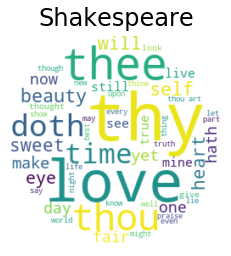

In [2]:
text = open(os.path.join(os.getcwd(), 'data/shakespeare.txt')).read()
wordcloud = text_to_wordcloud(text, title='Shakespeare')

## Helper Functions for processing the data

In [3]:
# Helper function for processing each word (Capitalization and special characters)
def parse_word(word, syllable_dict):
    word = word.lower()
    if word in syllable_dict:
        return word
    else:
        special_character_list= [',', '.', '?', '!', ';', ':', '(', ')', "'"]
        for j in range(2):
            if word[-1:] in special_character_list:
                word = word[:-1]
                if word in syllable_dict:
                    return word
            if word[:1] in special_character_list:
                word = word[1:]
                if word in syllable_dict:
                    return word
        return word
    
# Helper function for dealing with rhyme in the poems
def add_a_pair(word1, word2, rhyme_list):
    index1 = -1
    index2 = -1
    for i in range(len(rhyme_list)):
        if word1 in rhyme_list[i]:
            index1 = i
        if word2 in rhyme_list[i]:
            index2 = i
    if index1 > -1 and index2 > -1:
        rhyme_list[index1].update(rhyme_list[index2])
        rhyme_list.remove(rhyme_list[index2])
    elif index1 > -1 and index2 == -1:
        rhyme_list[index1].add(word2)
    elif index1 == -1 and index2 > -1:
        rhyme_list[index2].add(word1)
    elif index1 == -1 and index2 == -1:
        rhyme_list.append({word1, word2})    
        
def get_rhyme_dict(filename, syllable_dict):
    rhyme_dict = []
    file = open(os.path.join(os.getcwd(), filename)).read().split('\n')
    
    training_set = []
    poem = []
    for line in file:
        line_separate = line.split()
        if line_separate: 
            if len(line_separate) == 1:
                if len(poem) == 14:
                    training_set.append(poem)
                poem = []
                continue
            poem.append(line_separate)  
    
    for sonnet in training_set:
        # Following the given thyme scheme: abab-cdcd-efef-gg.
        for i in [0, 1, 4, 5, 8, 9]:
            word1 = parse_word(sonnet[i][-1], syllable_dict)
            word2 = parse_word(sonnet[i + 2][-1], syllable_dict)
            add_a_pair(word1, word2, rhyme_dict)
        # The last two terms of the rhyme in one poem
        add_a_pair(parse_word(sonnet[12][-1], syllable_dict), parse_word(sonnet[13][-1], syllable_dict), rhyme_dict)
    
    return rhyme_dict

    
# Helper function for reading the Syllable dictionary
def get_syllable_dict(filename):
    syllable_dict = {}
    file = open(os.path.join(os.getcwd(), filename)).read().split('\n')
    
    for line in file:
        if line.split():
            word_syllable = line.split()
            real_count = []
            end_count = []
            # Deal with the ending cases
            for i in range(1, len(word_syllable)):
                if word_syllable[i][0] == 'E':
                    end_count.append(int(word_syllable[i][1]))
                else:
                    real_count.append(int(word_syllable[i][0]))
            # Rank the syllable from the highest to the lowest        
            syllable_dict[word_syllable[0]] = [real_count[::-1], end_count[::-1]]

    return syllable_dict

# Helper function for getting the punctuation data
def get_punctuation_table(filename):
    
    file = open(os.path.join(os.getcwd(), filename)).read().split('\n')
    training_set = []
    poem = []
    for line in file:
        line_separate = line.split()
        if line_separate: 
            if len(line_separate) == 1:
                if len(poem) == 14:
                    training_set.append(poem)
                poem = []
                continue
            poem.append(line_separate)
    
    punc_frequency = [[0 for punctuation in range(7)] for stanza in range(4)]

    punctuation_list = [',', '.', ':', ';', '!', '?']
    odd_location1 = [0, 2, 4, 6, 8, 10] # 1st-3rd lines of 1st-3rd stanzas
    even_location2 = [1, 3, 5, 7, 9, 11] # 4th line of 1st-3rd stanzas

    for sonnet in training_set:
        for i in range(14):
            punc = sonnet[i][-1][-1]
            if punc in punctuation_list:
                punc_index = punctuation_list.index(punc)
            # No punctuation
            else:
                punc_index = 6
            if i in odd_location1:
                punc_frequency[0][punc_index] += 1
            elif i in even_location2:
                punc_frequency[1][punc_index] += 1
            elif i == 12:
                punc_frequency[2][punc_index] += 1
            elif i == 13:
                punc_frequency[3][punc_index] += 1
    
    return punc_frequency
    
# Helper function: imported from the template "HMM_helper.py" with little revision
def parse_observations(text, syllable_dict):
    # Convert text to dataset.
    lines = [line.split() for line in text.split('\n') if line.split()]
    
    obs_counter = 0
    obs = []
    obs_map = {}

    for line in lines:
        if len(line) == 1:
            continue
        
        # Reverse the line for rhyme training
        line.reverse()
        obs_elem = []
    
        for word in line:
            if word not in syllable_dict:
                word1 = parse_word(word, syllable_dict)
            else:
                word1 = word
            
            if word1 not in obs_map:
                # Add unique words to the observations map.
                obs_map[word1] = obs_counter
                obs_counter += 1
            
            # Add the encoded word.
            obs_elem.append(obs_map[word1])
        
        # Add the encoded sequence.
        obs.append(obs_elem)

    return obs, obs_map

## Data preprocessing (with helper functions)

In [4]:
# Reading the file
filename = 'data/shakespeare.txt'
syllable_name = 'data/Syllable_dictionary.txt'
Shakes_poem = open(os.path.join(os.getcwd(), filename)).read()

# Extracting observation and syllable_dict
syllable_dict = get_syllable_dict(syllable_name)
obs, obs_map = parse_observations(Shakes_poem, syllable_dict)

# Get the reversed word_map
word_map = {}
for key in obs_map:
    word_map[obs_map[key]] = key
rhyme_dict = get_rhyme_dict(filename, syllable_dict)
punctuation_list = get_punctuation_table(filename)

# Get the CMU NLTK dictionary
import nltk
stress_list = nltk.corpus.cmudict.entries()
stress_dict = {}
for word, breakdown in stress_list:
    unprocessed = []
    if word in stress_dict:
        stress_dict.get(word).append(breakdown)
    else:
        unprocessed.append(breakdown)
        stress_dict[word] = unprocessed

## Helper Functions for generating sentences and punctuations

In [5]:
# Generate a sentence without rhyme
def sentence_without_rhyme(hmm, word_map, M_syllable = 10):
    emission, states = hmm.generate_emission(M_syllable, word_map, syllable_dict)
    sentence = [word_map[i] for i in emission][::-1]
    sentence[0] = sentence[0].capitalize()
    return ' '.join(sentence)

# Generate a sentence with a given word at the end (helper function for rhyme generator)
def sentence_with_given_end(hmm, given_word, M_syllable = 10):
    # Choose a state that could have generated the word
    given_state = hmm.find_state(obs_map[given_word])
    
    # Sample and reverse the sentence
    emission, states = hmm.generate_emission_rhyme_stress(given_word, given_state, M_syllable, word_map, obs_map, 
                                                          syllable_dict, stress_dict)
    sentence = [word_map[i] for i in emission][::-1]
    sentence[0] = sentence[0].capitalize()
    return ' '.join(sentence)

# Generate sentence pairs with rhyme
def sentences_pair_with_rhyme(hmm, rhyme_dict, M_syllable = 10, N_sentences = 2):
    # Choose a rhyming group with enough words
    rhyme_group = []
    for group in rhyme_dict:
        if len(group) >= N_sentences:
            rhyme_group.append(group)

    # Choose a group of rhyme word
    chosen_group = random.choice(rhyme_group)
    words = random.sample(chosen_group, N_sentences)
    
    sentence_pair = []
    for word in words:
        sentence_pair.append(sentence_with_given_end(hmm, word, M_syllable))
        
    return sentence_pair

# Punctuation generator
def punc_generator(location):
    punctuation_choice = [',', '.', ':', ';', '!', '?']
    chosen_index = random.choices(range(len(punctuation_list[location])), weights=punctuation_list[location])[0]
    if chosen_index == 6:
        return ''
    else:
        return punctuation_choice[chosen_index]

## Helper functions for generating entire sonnet

In [6]:
# Generate a sonnet without rhyme and stress
def generate_sonnet(hmm, word_map, M_syllable = 10):
    poem = ''
    for i in range(12):
        if i % 2 == 0:
            poem += sentence_without_rhyme(hmm, word_map, M_syllable) + punc_generator(0) + '\n'
        else:
            poem += sentence_without_rhyme(hmm, word_map, M_syllable) + punc_generator(1) + '\n'
    # Last stanza
    poem += '  ' + sentence_without_rhyme(hmm, word_map, M_syllable) + punc_generator(2) + '\n  '
    poem += sentence_without_rhyme(hmm, word_map, M_syllable) + punc_generator(3) + '\n'
    print(poem)    
    
    
# Generate a sonnet in Shakespeare's style (with rhyme and stress)
def generate_sonnet_rhyme_stress(hmm, rhyme_dict):
    poem = ''
    # The first three stanzas (abab)
    for stanza in range(3):
        l1, l3 = sentences_pair_with_rhyme(hmm, rhyme_dict)
        l2, l4 = sentences_pair_with_rhyme(hmm, rhyme_dict)
        poem += (l1 + punc_generator(0) + '\n' + l2 + punc_generator(1) + '\n' + 
                l3 + punc_generator(0) + '\n' + l4 + punc_generator(1) + '\n' + '\n')
        
    # last stanza (gg)
    l5, l6 = sentences_pair_with_rhyme(hmm, rhyme_dict)
    poem += '  ' + l5 + punc_generator(2) + '\n  ' + l6 + punc_generator(3) + '\n' 
    print(poem)

# Generate a Haiku sonnet (3 sentences, syllables: 5 + 7 + 5)      
def generate_sonnet_haikus(hmm, word_map):
    print(sentence_without_rhyme(hmm, word_map, M_syllable = 5))
    print(sentence_without_rhyme(hmm, word_map, M_syllable = 7))
    print(sentence_without_rhyme(hmm, word_map, M_syllable = 5))

# Generate a petrachan sonnet (14 sentences, each with 10 syllables, rhyme: abbaabba, cdcdcd)    
def generate_sonnet_petrarchan(hmm, rhyme_dict):
    poem = ''
    
    a = sentences_pair_with_rhyme(hmm, rhyme_dict, M_syllable = 10, N_sentences = 4)
    b = sentences_pair_with_rhyme(hmm, rhyme_dict, M_syllable = 10, N_sentences = 4)
    c = sentences_pair_with_rhyme(hmm, rhyme_dict, M_syllable = 10, N_sentences = 3)
    d = sentences_pair_with_rhyme(hmm, rhyme_dict, M_syllable = 10, N_sentences = 3)

    poem += (a[0] + '\n' + b[0] + '\n' + b[1] + '\n' + a[1] + '\n' +a[2] + '\n' + b[2] + '\n' + b[3] + '\n' + a[3] + '\n'
             + '\n' + c[0] + '\n' + d[0] + '\n' + c[1] + '\n' + d[1] + '\n' + c[2] + '\n' + d[2] + '\n')
    
    print(poem)
    
# Generate a limerick sonnet (5 sentences, each with a , rhyme: aabba)    
def generate_sonnet_limerick(hmm, rhyme_dict):
    poem = ''
    
    a = sentences_pair_with_rhyme(hmm, rhyme_dict, M_syllable = random.randint(7, 10), N_sentences = 3)
    b = sentences_pair_with_rhyme(hmm, rhyme_dict, M_syllable = random.randint(5, 7), N_sentences = 2)
    
    poem += (a[0] + '\n' + a[1] + '\n' + b[0] + '\n' + b[1] + '\n' + a[2] + '\n')
    print(poem)

## Training the HMM models, Generate poems and Visualization

### HMM with 2 hidden states

In [7]:
hmm2 = unsupervised_HMM(obs, 2, 100)

0
Iteration: 0
1
2
3
4
5
Iteration: 5
6
7
8
9
10
Iteration: 10
11
12
13
14
15
Iteration: 15
16
17
18
19
20
Iteration: 20
21
22
23
24
25
Iteration: 25
26
27
28
29
30
Iteration: 30
31
32
33
34
35
Iteration: 35
36
37
38
39
40
Iteration: 40
41
42
43
44
45
Iteration: 45
46
47
48
49
50
Iteration: 50
51
52
53
54
55
Iteration: 55
56
57
58
59
60
Iteration: 60
61
62
63
64
65
Iteration: 65
66
67
68
69
70
Iteration: 70
71
72
73
74
75
Iteration: 75
76
77
78
79
80
Iteration: 80
81
82
83
84
85
Iteration: 85
86
87
88
89
90
Iteration: 90
91
92
93
94
95
Iteration: 95
96
97
98
99


In [8]:
generate_sonnet(hmm2, word_map, M_syllable = 10)

To in not sword self you yield thou adieu,
Had they be needs sweet from be gold alone,
All yet and and wasteful my thou not so,
And my anger never seen that weigh as.
You that rights dost hold which shalt now kind my
Derive is bright be you wide those busy,
Of canst after a creature bear outward,
Mine hath weigh send'st these this to i the quest?
All what and to were should do you knows men,
Her from may and friend not let till i the,
Their my wherein know tame distempered and,
Thine do a for art for prove all befits,
  Love put is needs would faults the excusing,
  Nor dun love thee the it of from that to.



In [9]:
generate_sonnet_rhyme_stress(hmm2, rhyme_dict)

Unrespected and stelled love winged hearts,
Even root gild'st give rhymers have resty bait,
Gav'st praise suborned thou is't once discased parts,
Pour'st she dateless to riper fair need'st straight,

Being bred being new fleet'st will prevent'st with fulness,
Nor haply where being angel methinks up.
Inferior praise 'gainst being a wronk the dulness
How murd'rous as unseeing it gav'st cup!

Stol'n woe goest were beauty's his stol'n afloat,
His o'er sight beauty's broke unkindness man:
Spirit i power and keep'st wherewith and many boat,
Slanderers is virtuous looks many's can,

  Alt'ring celestial self-substantial hooks,
  Bett'ring interim mayst my immured looks.



In [10]:
generate_sonnet_haikus(hmm2, word_map)

Drop so none in thou
You loss this though prove but die
Of ruinate hour


In [11]:
generate_sonnet_petrarchan(hmm2, rhyme_dict)

You o'er-read crow prevent'st feast niggarding
To beauteous this kind-hearted devour stout
Power made self-doing one thriftless about
Wakened lovely murd'rous my many's king
Thou liker despair whereto ordering
Given it worthier expiate inhearse out
Can th' to dully not beauteous show even doubt
Present'st fixed self-doing of beauty's spring

Flower this tongue-tied thy methinks in wombs brings
Saith up soul's pen raiment on brav'ry pain
Memorial woe travel's decay grow'st kings
A pity-wanting oppressed besmeared twain
Heaven buried profaned sovereign whereto things
Whereon and saith fair 'scaped that alien main



In [12]:
generate_sonnet_limerick(hmm2, rhyme_dict)

Stol'n time honour injury
Play'st numbers neigh liberty
For't praise canst stones being world seeming
Nor power outbraves warmed esteeming
My shouldst for hadst poverty



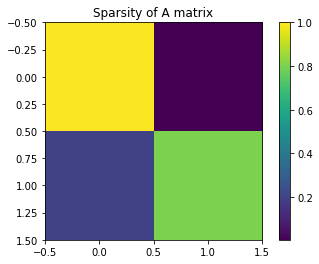

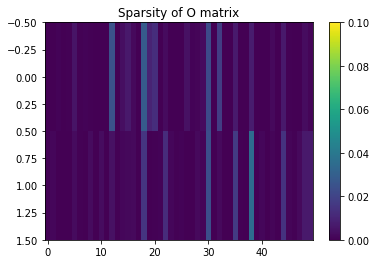

In [13]:
visualize_sparsities(hmm2, O_max_cols=50)

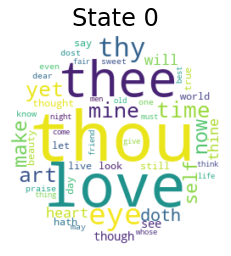

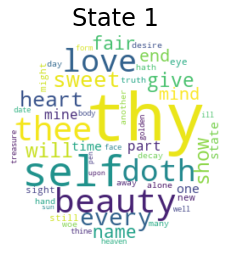

In [14]:
wordclouds2 = states_to_wordclouds(hmm2, word_map, syllable_dict)

### HMM with 4 hidden states

In [15]:
hmm4 = unsupervised_HMM(obs, 4, 100)

0
Iteration: 0
1
2
3
4
5
Iteration: 5
6
7
8
9
10
Iteration: 10
11
12
13
14
15
Iteration: 15
16
17
18
19
20
Iteration: 20
21
22
23
24
25
Iteration: 25
26
27
28
29
30
Iteration: 30
31
32
33
34
35
Iteration: 35
36
37
38
39
40
Iteration: 40
41
42
43
44
45
Iteration: 45
46
47
48
49
50
Iteration: 50
51
52
53
54
55
Iteration: 55
56
57
58
59
60
Iteration: 60
61
62
63
64
65
Iteration: 65
66
67
68
69
70
Iteration: 70
71
72
73
74
75
Iteration: 75
76
77
78
79
80
Iteration: 80
81
82
83
84
85
Iteration: 85
86
87
88
89
90
Iteration: 90
91
92
93
94
95
Iteration: 95
96
97
98
99


In [16]:
generate_sonnet(hmm4, word_map, M_syllable = 10)

Knife pain every for excusing youth should,
My heart to will until and fate not but.
Altered with others cease hand yet confounds,
To doth mine whilst we directly but the?
Come and my hath on thee trimmed from therefore,
Tempests will you to joy in for breast i,
Not of salve see very from strength youth jacks,
Thine night in to and his pass but my mine.
Broken very give of your to thy and
Heart thought heaven's earth things in no she chase
To what hast or thereof or is choose deep,
Those put my have 'scaped to loved is thou of:
  Arrest written external good resty,
  They body sick was plagues and proves glass my.



In [17]:
generate_sonnet_rhyme_stress(hmm4, rhyme_dict)

Nothing batt'ring and beauty's breast inhearse
With attainted unless unfathered fall.
Thievish speed profaned thee offences verse,
Breathers by wantonness while burthen call.

Grow'st why youngly for bosoms should forgotten,
Highmost war being my burthen delves canst sheaves,
Same o'er-green youth incertainties we rotten,
Whereto motion unused of canst leaves:

Refigured truth being of power skill desire,
Me powers gold assured i metre ghost.
Happies state tired you whate'er and conspire:
Doom 'twixt virtue miscalled and forged lost,

  When unwooed i gav'st love tired best heaven beck,
  Wretch to shouldst a self-willed may winged check.



In [18]:
generate_sonnet_haikus(hmm4, word_map)

Set things losses find
Wastes in this eyes my we filed
Same but is my sum


In [19]:
generate_sonnet_petrarchan(hmm4, rhyme_dict)

Child spites whereto all beauteous full spirit doubt
Sourly was satire state dear-purchased costs
Part whereto so know'st desire my erst most
Thy self-same cruel mayst yet flattery stout
From uttering truth beauty's of placed out
Even i engraft you twire merits either lost
Mayst with besmeared thou lov'st do dateless boast
Thus frown'st the offender's be whether about

Gav'st was stol'n leaves methinks used away
His th' behold whate'er conquest shadow's finds
Bett'ring this heaven winter's maketh of th' day
Powers dregs self-willed i present'st nor couldst winds
Immured love forget'st from virtuous sway
Loss vouchsafe that desire love 'greeing minds



In [20]:
generate_sonnet_limerick(hmm4, rhyme_dict)

Lov'st eternal outworn most wand'ring fears
Mayst do unfathered that given honour clears
Drudge didst thine assemble
Pebbled their resemble
Flattery cools inferior her forget'st tears



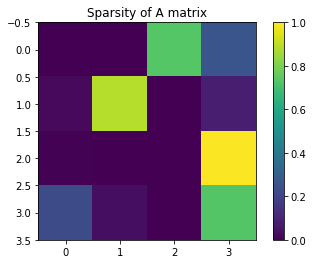

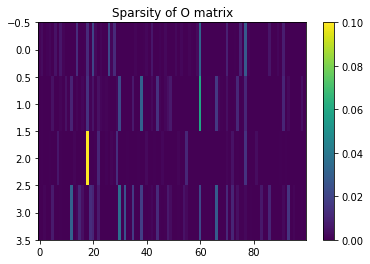

In [21]:
visualize_sparsities(hmm4, O_max_cols=100)

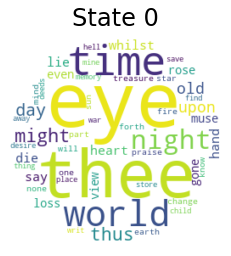

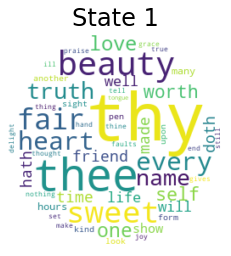

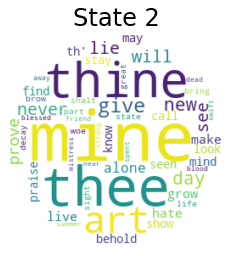

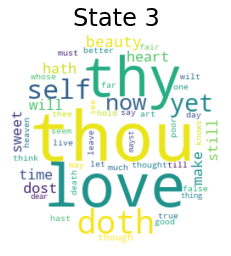

In [22]:
wordclouds4 = states_to_wordclouds(hmm4, word_map, syllable_dict)

### HMM with 8 hidden states

In [23]:
hmm8 = unsupervised_HMM(obs, 8, 100)

0
Iteration: 0
1
2
3
4
5
Iteration: 5
6
7
8
9
10
Iteration: 10
11
12
13
14
15
Iteration: 15
16
17
18
19
20
Iteration: 20
21
22
23
24
25
Iteration: 25
26
27
28
29
30
Iteration: 30
31
32
33
34
35
Iteration: 35
36
37
38
39
40
Iteration: 40
41
42
43
44
45
Iteration: 45
46
47
48
49
50
Iteration: 50
51
52
53
54
55
Iteration: 55
56
57
58
59
60
Iteration: 60
61
62
63
64
65
Iteration: 65
66
67
68
69
70
Iteration: 70
71
72
73
74
75
Iteration: 75
76
77
78
79
80
Iteration: 80
81
82
83
84
85
Iteration: 85
86
87
88
89
90
Iteration: 90
91
92
93
94
95
Iteration: 95
96
97
98
99


In [24]:
generate_sonnet(hmm8, word_map, M_syllable = 10)

Which thee and infection do beauty's hell,
Doth by hath blame vice me when fell spirit reeks,
Name to wondrous fury to whether the,
Self in now interest on by and thy boy,
Name and doth change it knows forgive the world
The love of wondrous self and earth you thee,
Shalt let the best of none perjured to thy,
I that beauty make eyes with is day is;
When thy rotten in apple me did now,
Fault sweet the can grown their me see doth check.
Day in water broils of master the draw,
Born great of if hied but a abysm red,
  To that that colour both determined,
  Me man love thence what thy ne'er no win now.



In [25]:
generate_sonnet_rhyme_stress(hmm8, rhyme_dict)

Well-contented hear injurious defect,
Canst else beauteous a stol'n then famoused slave.
Whoe'er take winged bore bounteous respect
Awakes nightly feel'st made injurious crave.

Can effectually first kind-hearted done,
Seen t' that self-willed deeds even possessed uprear?
Hill happier thy dyer's all vilest dun
Own bootless whom inconstant beauteous here,

Tongue's i self-love but suborned draw amazeth,
Mine supposed thee th' a poesy bear
More soundless hath even of gentlest will gazeth,
Eye beauteous and thither but bristly swear?

  Condemned nor whether therefore honour told
  Feed'st both self-killed on given to heavenly old.



In [26]:
generate_sonnet_haikus(hmm8, word_map)

The why withal me
Nor thou deeds besides within
Quest and have not me


In [27]:
generate_sonnet_petrarchan(hmm8, rhyme_dict)

Tongue's canst that mightst thy soul's to niggarding
Die physic my seemly that carcanet
Being sum well-seeing boast robbery unset
Being thou bareness as to-day since tired wing
Angel outbraves above shouldst thou being bring
And beshrew thy bosom's and blessed set
Whether them where-through do thyself counterfeit
Wanting ever-fixed time's censures sing

Anon suff'ring lovers surety-like thence
Heaven's do receiv'st thy worthier sensual there
Being thy power dies starved much run'st defence
Showers were thriftless flame whereto shapes o'er were
My steep-up as methinks intelligence
Mortal mayst as heaven thou millioned elsewhere



In [28]:
generate_sonnet_limerick(hmm8, rhyme_dict)

Accuse powers praise canst it given wide
Posting even of alt'ring belied
Edge 'gainst since tombed hems
Valley-fountain gems
Beated a slavery this even slide



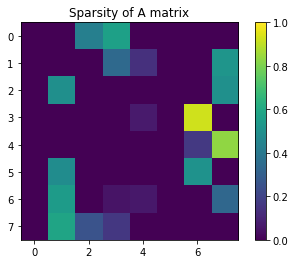

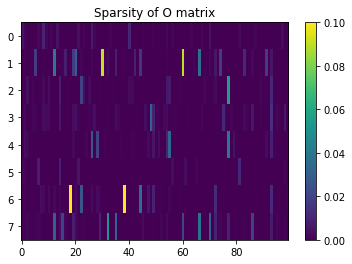

In [29]:
visualize_sparsities(hmm8, O_max_cols=100)

## Wordcloud Visualization

In [31]:
hmm6 = unsupervised_HMM(obs, 6, 100)

0
Iteration: 0
1
2
3
4
5
Iteration: 5
6
7
8
9
10
Iteration: 10
11
12
13
14
15
Iteration: 15
16
17
18
19
20
Iteration: 20
21
22
23
24
25
Iteration: 25
26
27
28
29
30
Iteration: 30
31
32
33
34
35
Iteration: 35
36
37
38
39
40
Iteration: 40
41
42
43
44
45
Iteration: 45
46
47
48
49
50
Iteration: 50
51
52
53
54
55
Iteration: 55
56
57
58
59
60
Iteration: 60
61
62
63
64
65
Iteration: 65
66
67
68
69
70
Iteration: 70
71
72
73
74
75
Iteration: 75
76
77
78
79
80
Iteration: 80
81
82
83
84
85
Iteration: 85
86
87
88
89
90
Iteration: 90
91
92
93
94
95
Iteration: 95
96
97
98
99


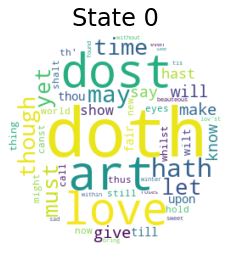

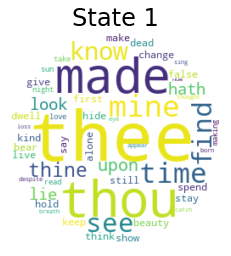

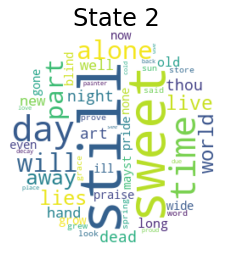

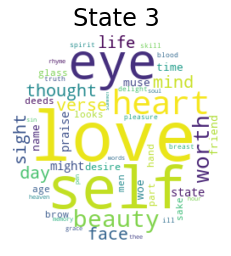

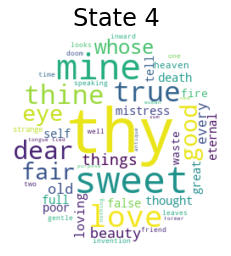

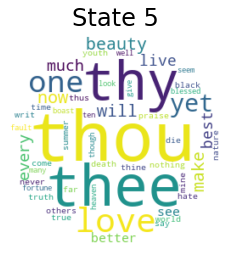

In [32]:
wordclouds6 = states_to_wordclouds(hmm6, word_map, syllable_dict)